### 숫자 인식, MLP

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time

import numpy as np
import pandas as pd
import seaborn as sb

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
# windows 10
# font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgunsl.ttf").get_name()
rc('font', family=font_name)           # 맑은 고딕 폰트 지정
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline  

In [2]:
# 최초에만 다운로드 발생
(x_train, y_train), (x_test, y_test)  = mnist.load_data()
width=28
height=28

print('x_train:', x_train.shape)
# 전결합층은 1차원 형태의 나열된 데이터여야함.
x_train = x_train.reshape(x_train.shape[0], width * height).astype('float32') / 255 # 60000행  X 784열
print('x_train:', x_train.shape)

x_test = x_test.reshape(x_test.shape[0], width * height).astype('float32') / 255 # 10000 X 784


x_train: (60000, 28, 28)
x_train: (60000, 784)


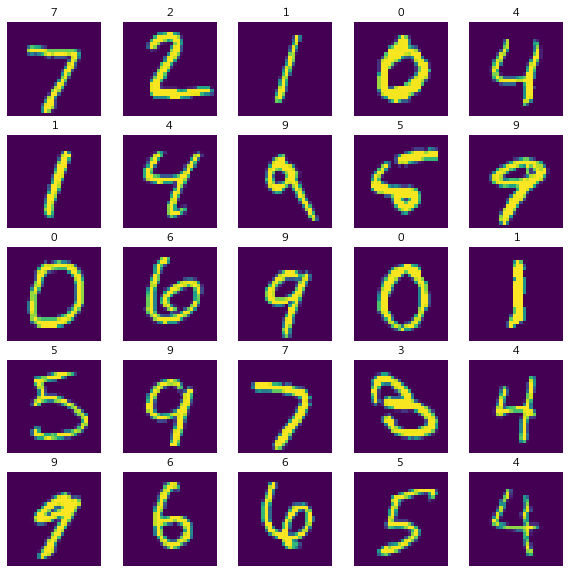

In [3]:
# 데이터 확인
plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10) # 이미지 사이즈 설정

f, axarr = plt.subplots(plt_row, plt_col) # 5행 5열 배열 plot 구조 생성

for i in range(plt_row * plt_col): # 25: 0 ~ 24
    sub_plt = axarr[i // plt_row, i % plt_col] # 행열 위치 설정
    sub_plt.axis('off') # 축 label 출력 생략
    
    # 1차원 배열 -> 2차원 배열로 변경
    # 2차원 이미지로 출력하기위해 784 -> 28행 28열로 변경
    sub_plt.imshow(x_test[i].reshape(width, height))  
    
    sub_plt_title = y_test[i] 
        
    sub_plt.set_title(sub_plt_title) # 이미지 제목

plt.show()

In [4]:
# 홀수는 1, 짝수는 0
print(y_test[0:3])
y_train = to_categorical(y_train, 10)  # One-Hot encoding
y_test = to_categorical(y_test, 10)
print(y_test.shape)
print(y_test[0:3])

[7 2 1]
(10000, 10)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [8]:
seed = 0 # 난수용 
width=28
height=28

(x_train_all, y_train_all), (x_test, y_test)  = mnist.load_data()

x_train_all = x_train_all.reshape(x_train_all.shape[0], width * height).astype('float32') / 255 # 60000행  X 784열
x_test = x_test.reshape(x_test.shape[0], width * height).astype('float32') / 255 # 10000 X 784

y_train_all = to_categorical(y_train_all, 10)  # One-Hot encoding
y_test = to_categorical(y_test, 10)

# 80%: 훈련, 20%: 검증
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all,
                                                  test_size=0.2,
                                                  random_state=seed)

model = Sequential()
model.add(Dense(4, input_dim=784, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', 
                                metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='loss', patience=1)
start = time.time()
# 장비 속도가 느려 3번만 진행
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, 
                 batch_size=50, callbacks=[early_stopping])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))

# MLP기반에 CPU, GPU 사용시 왜 GUP가 느린 이유
# - 데이터가 아주 작을 경우, CPU가 GPU를 제어하는 시간 필요
# - Dense는 CPU에 최적화 되어 학습되는 구조
# - Dense에서도 가중치와 편향이 많아지면 GPU가 빨라짐.
# cpu: 62 초
# gpu: 241 초



Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 2s 41us/sample - loss: 1.3096 - accuracy: 0.5412 - val_loss: 0.8911 - val_accuracy: 0.7372
Epoch 2/3
48000/48000 [==============================] - 1s 31us/sample - loss: 0.7617 - accuracy: 0.7741 - val_loss: 0.7030 - val_accuracy: 0.7977
Epoch 3/3
48000/48000 [==============================] - 2s 31us/sample - loss: 0.6519 - accuracy: 0.8090 - val_loss: 0.6386 - val_accuracy: 0.8195
Runtime: 4.98 초


In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4)                 3140      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50        
Total params: 3,190
Trainable params: 3,190
Non-trainable params: 0
_________________________________________________________________


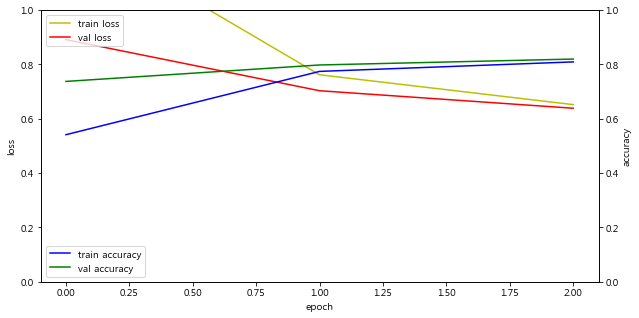

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 왼쪽 y축 레이블, 오차
acc_ax.set_ylabel('accuracy') # 오른쪽 y축 레이블, 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [11]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.6357159637761921 /정확도: 81.62000179290771 %


In [12]:
model.save('./Mnist3_mlp.h5')

In [13]:
model = load_model('./Mnist3_mlp.h5')

In [14]:
yp = model.predict(x_test, batch_size=32)
print(yp[0:10])

[[1.2291817e-06 2.3056401e-09 7.9006037e-05 5.0575483e-05 1.8605727e-04
  4.8338546e-09 7.8929663e-09 9.8696458e-01 3.5603745e-07 1.2718157e-02]
 [1.1904944e-04 2.9192945e-10 8.4200162e-01 1.0781917e-03 1.7371771e-09
  2.5721567e-06 1.5679325e-01 3.2889466e-16 5.1799684e-06 4.5829358e-11]
 [7.8787562e-05 8.6161238e-01 1.9044249e-03 5.6559552e-02 4.8018964e-03
  4.6947211e-02 3.3515703e-03 1.2052364e-04 2.1684803e-02 2.9390154e-03]
 [9.9648094e-01 2.1035194e-11 4.4580959e-04 1.2092914e-07 2.4004940e-04
  1.9426302e-04 2.6095663e-03 2.3794894e-07 2.5571642e-05 3.4663740e-06]
 [7.5443783e-03 1.7837991e-06 8.6703934e-03 7.0689234e-04 5.7367957e-01
  2.2600328e-03 9.8791637e-04 2.4004273e-02 3.6385030e-02 3.4575966e-01]
 [9.6308977e-06 8.6450577e-01 1.5110491e-03 8.1980534e-02 4.4407882e-03
  1.6756956e-02 1.1142606e-03 1.0861691e-04 2.4826242e-02 4.7462010e-03]
 [3.0231000e-05 4.0536737e-03 7.5149501e-06 5.7253743e-05 6.5358531e-01
  4.5038048e-02 7.3858762e-05 3.3697246e-03 1.3721944e-01 

In [15]:
cnt = 0
for i in range(10): # 0 ~ 9
    title = str(np.argmax(y_test[i])) + ' / ' + str(np.argmax(yp[i]))
    print(title)


7 / 7
2 / 2
1 / 1
0 / 0
4 / 4
1 / 1
4 / 4
9 / 9
5 / 5
9 / 9


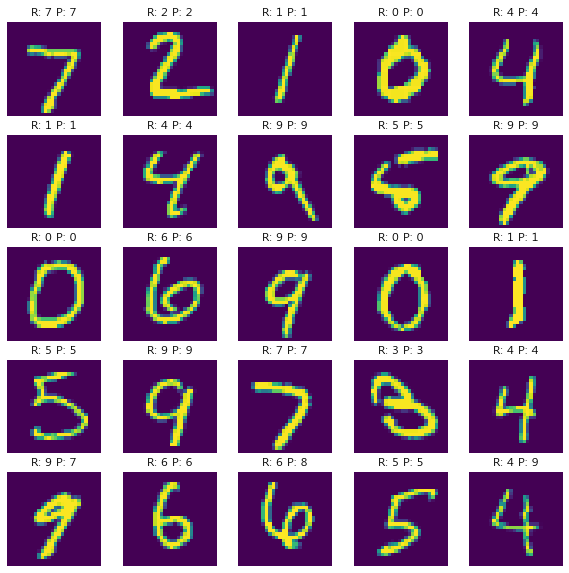

In [16]:
# 모델 사용하기
yhat_test = model.predict(x_test, batch_size=32)

plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

cnt = 0
i = 0

while cnt < (plt_row*plt_col):
    sub_plt = axarr[cnt//plt_row, cnt%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    sub_plt_title = 'R: ' + str(np.argmax(y_test[i])) + ' P: ' + str(np.argmax(yhat_test[i]))
    sub_plt.set_title(sub_plt_title)

    i += 1    
    cnt += 1

plt.show()


## evaluation loss and_metrics ##
손실값: 0.6357159576892852  정확도: 81.62000179290771


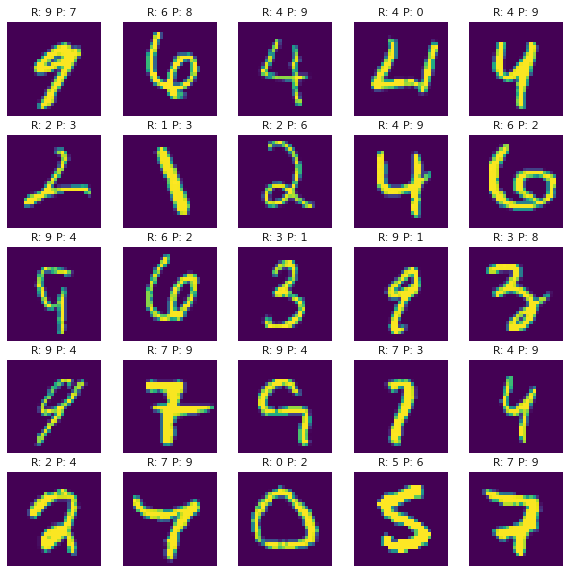

In [17]:
# 오답 이미지만 출력
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32, verbose=0)
print('## evaluation loss and_metrics ##')
print('손실값:',loss_and_metrics[0], ' 정확도:', (loss_and_metrics[1] * 100))

yhat_test = model.predict(x_test, batch_size=32)

plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

cnt = 0
i = 0

while cnt < (plt_row*plt_col):
    
    if np.argmax(y_test[i]) == np.argmax(yhat_test[i]):
        i += 1
        continue # 정답일 경우 출력 안함.
    
    sub_plt = axarr[cnt//plt_row, cnt%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    sub_plt_title = 'R: ' + str(np.argmax(y_test[i])) + ' P: ' + str(np.argmax(yhat_test[i]))
    sub_plt.set_title(sub_plt_title)

    i += 1    
    cnt += 1

plt.show()
